In [1]:
from SimPEG import *
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP.StretchedExponential import SEInvImpulseProblem, SESurvey
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
from simpegEM1D import DigFilter

def ColeColePelton(f, sigmaInf, eta, tau, c):
    w = 2*np.pi*f
    return sigmaInf*(1 - eta/(1 + (1-eta)*(1j*w*tau)**c))

def ColeColeSeigel(f, sigmaInf, eta, tau, c):
    w = 2*np.pi*f
    return sigmaInf*(1 - eta/(1 + (1j*w*tau)**c))

time = np.logspace(-6,np.log10(0.01), 41)
wt, tbase, omega_int = DigFilter.setFrequency(time)
frequency = omega_int / (2*np.pi)
siginf, eta0, tau0, c0 = 1., 0.8, 0.003, 0.6
sigma = ColeColeSeigel(frequency, siginf, eta0, tau0, c0)
sigTCole = DigFilter.transFiltImpulse(sigma, wt, tbase, omega_int, time, tol=1e-12)
wires = Maps.Wires(('eta', 1), ('tau', 1), ('c', 1))
taumap = Maps.ExpMap(nP=1)*wires.tau
survey = SESurvey()
dtrue = -sigTCole
survey.dobs = dtrue
m1D = Mesh.TensorMesh([np.ones(3)])
prob = SEInvImpulseProblem(m1D, etaMap = wires.eta, tauMap = taumap, cMap=wires.c)
update_sens = Directives.UpdateSensitivityWeights()
prob.time = time
prob.pair(survey)
m0 = np.r_[eta0, np.log(tau0), c0]
perc = 0.01
dmisfitpeta = DataMisfit.l2_DataMisfit(survey)
dmisfitpeta.W = 1/(abs(survey.dobs)*perc)
reg = Regularization.Simple(m1D)
opt = Optimization.ProjectedGNCG(maxIter = 10)
invProb = InvProblem.BaseInvProblem(dmisfitpeta, reg, opt)
# Create an inversion object
target = Directives.TargetMisfit()
betaSch = Directives.BetaSchedule(coolingFactor=1, coolingRate=1)
# invProb.beta = 0.
inv = Inversion.BaseInversion(invProb, directiveList=[betaSch, target])
reg.mref = 0.*m0
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
opt.tolX = 1e-20
opt.tolF = 1e-20
opt.tolG = 1e-20
opt.eps = 1e-20
# opt.lower = 0.
mopt = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  4.66e+03  5.98e+01  4.72e+03    1.20e+05      0              
   1  1.00e+00  2.74e+02  6.23e+01  3.36e+02    8.08e+03      0              
   2  1.00e+00  2.13e+02  6.35e+01  2.76e+02    1.39e+02      0   Skip BFGS  
   3  1.00e+00  2.13e+02  6.35e+01  2.76e+02    3.90e+00      0   Skip BFGS  
   4  1.00e+00  2.13e+02  6.35e+01  2.76e+02    1.06e-01      0              
   5  1.00e+00  2.13e+02  6.35e+01  2.76e+02    2.90e-03      0              
   6  1.00e+00  2.13e+02  6.35e+01  2.76e+02   

In [3]:
def ColeSEImpulse(time, eta, tau, c):    
    return eta*c/time*((time/tau)**c)*np.exp(-(time/tau)**c)
def ColeSEImpulseApprox(time, eta, tau, c):    
    m = eta*c/(tau**c)    
    peta = m*time**(c-1.) * (1. - (time/tau)**c )  
    return peta

In [7]:
from SimPEG import EM

True      eta, tau and c = 8e-01, 3e-03 and 0.6
Initial   eta, tau and c = 8e-01, 3e-03 and 0.6
Estimated eta, tau and c = 7e-01, 2e-03 and 0.6


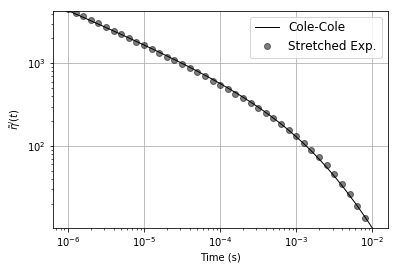

In [8]:
nskip=1
fig = plt.figure()
plt.loglog(prob.time, survey.dobs, 'k', lw=1)
plt.loglog(prob.time, invProb.dpred, 'ko', alpha = 0.5)
vmin, vmax = survey.dobs.min(), survey.dobs.max()
plt.ylim(vmin, vmax)
# legend(("pred", "obs"))
print (("True      eta, tau and c = %.e, %.e and %3.1f")%(eta0, tau0, c0))
print (("Initial   eta, tau and c = %.e, %.e and %3.1f")%(eta0, tau0, c0))
print (("Estimated eta, tau and c = %.e, %.e and %3.1f")%(mopt[0], np.exp(mopt[1]), mopt[2]))

plt.xlabel("Time (s)")
plt.ylabel("$\\tilde {\eta}^I (t)$")
plt.legend(("Cole-Cole", "Stretched Exp."), fontsize = 12)
plt.grid(True)
# fig.savefig("")

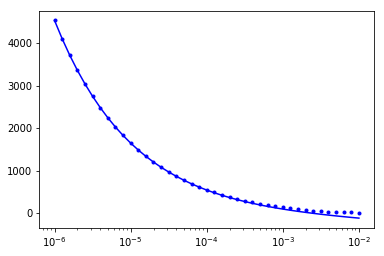

In [9]:
plt.semilogx(prob.time, ColeSEImpulseApprox(prob.time, mopt[0], np.exp(mopt[1]), mopt[2]), 'b-')
plt.semilogx(prob.time, ColeSEImpulse(prob.time, mopt[0], np.exp(mopt[1]), mopt[2]), 'b.')

In [49]:
mesh.vectorCCx

array([   5.        ,   15.        ,   25.        ,   35.        ,
         45.        ,   55.        ,   65.        ,   75.        ,
         85.        ,   95.        ,  105.        ,  115.        ,
        125.        ,  135.        ,  145.        ,  155.        ,
        165.        ,  175.        ,  185.        ,  195.        ,
        206.5       ,  221.45      ,  240.885     ,  266.1505    ,
        298.99565   ,  341.694345  ,  397.2026485 ,  469.36344305,
        563.17247597,  685.12421875,  843.66148438, 1049.7599297 ,
       1317.6879086 , 1665.99428118, 2118.79256554])

In [55]:
mesh.vectorNz

array([-2274.72203061, -1762.86310047, -1369.1254619 , -1066.25035531,
        -833.26950408,  -654.05346468,  -516.19497283,  -410.1499791 ,
        -328.576907  ,  -265.82839   ,  -217.5603    ,  -180.431     ,
        -151.87      ,  -129.9       ,  -113.        ,  -100.        ,
         -90.        ,   -80.        ,   -70.        ,   -60.        ,
         -50.        ,   -40.        ,   -30.        ,   -20.        ,
         -10.        ,     0.        ,    10.        ,    20.        ,
          30.        ,    40.        ,    50.        ,    60.        ,
          70.        ,    80.        ,    90.        ,   100.        ,
         113.        ,   129.9       ,   151.87      ,   180.431     ,
         217.5603    ,   265.82839   ,   328.576907  ,   410.1499791 ,
         516.19497283,   654.05346468,   833.26950408,  1066.25035531,
        1369.1254619 ,  1762.86310047,  2274.72203061])

In [112]:
from simpegEMIP.TDEM import Problem3D_e, BaseTDEMIPProblem
from simpegEMIP.Base import BaseEMIPProblem
eta, tau, c = mopt[0], np.exp(mopt[1]), mopt[2]
cs, ncx, ncz, npad = 10., 20, 20, 15
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
sig_half = 0.01
sigmaInf = np.ones(mesh.nC) * sig_half
airind = mesh.gridCC[:,2]>0.
sigmaInf[airind] = 1e-8
etavec = np.ones(mesh.nC) * eta
etavec[airind] = 0.
tauvec = np.ones(mesh.nC) * tau
cvec = np.ones(mesh.nC) * c
wiresEM = Maps.Wires(('sigmaInf', mesh.nC), ('eta', mesh.nC), ('tau', mesh.nC), ('c', mesh.nC))
tauvecmap = Maps.ExpMap(nP=mesh.nC) * wiresEM.tau
rxloc = np.array([[100., 0., 50.]])
srcloc = np.array([[0., 0., 50.]])
rx = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
src = EM.TDEM.Src.MagDipole([rx], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc)
survey = EM.TDEM.Survey([src])
prb_em = Problem3D_e(mesh, sigmaInfMap=wiresEM.sigmaInf, etaMap=wiresEM.eta, tauMap=tauvecmap, cMap=wiresEM.c)
prb_em.verbose = True
prb_em.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
prb_em.Solver = PardisoSolver
prb_em.pair(survey)
m = np.r_[sigmaInf, etavec, np.log(tauvec), cvec]
data = survey.dpred(m)

Calculating Initial fields
**************************************************
Calculating fields(m)
**************************************************
Factoring...   (dt = 1.000000e-06)
Done
    Solving...   (tInd = 1)
    Done...
    Solving...   (tInd = 2)
    Done...
    Solving...   (tInd = 3)
    Done...
    Solving...   (tInd = 4)
    Done...
    Solving...   (tInd = 5)
    Done...
Factoring...   (dt = 2.500000e-06)
Done
    Solving...   (tInd = 6)
    Done...
    Solving...   (tInd = 7)
    Done...
    Solving...   (tInd = 8)
    Done...
    Solving...   (tInd = 9)
    Done...
    Solving...   (tInd = 10)
    Done...
Factoring...   (dt = 5.000000e-06)
Done
    Solving...   (tInd = 11)
    Done...
    Solving...   (tInd = 12)
    Done...
    Solving...   (tInd = 13)
    Done...
    Solving...   (tInd = 14)
    Done...
    Solving...   (tInd = 15)
    Done...
Factoring...   (dt = 1.000000e-05)
Done
    Solving...   (tInd = 16)
    Done...
    Solving...   (tInd = 17)
    Done...
 

In [113]:
from EMTD.Utils import hzAnalyticDipoleT, hzAnalyticDipoleT_CC

In [114]:
from simpegEM1D import EM1D, EM1DSurveyTD, Utils1D, get_vertical_discretization_time, set_mesh_1d
import numpy as np
mesh1D = Mesh.TensorMesh([1])
TDsurvey = EM1DSurveyTD(
    rx_location = np.array([0., 0., 50.]),
    src_location = np.array([0., 0., 50.]),
    topo = np.r_[0., 0., 0.],
    offset = np.r_[100.],
    depth = np.r_[0.],
    rx_type = 'dBzdt',
    wave_type = 'stepoff',
    src_type = 'VMD',
    a = 13.,
    I = 1.,
    time = rx.times.copy(),
    half_switch=True
)
tau_p = tau0 / (1-eta0)**(1./c0)
expmap = Maps.ExpMap(mesh1D)
prob = EM1D(mesh1D, sigma=np.r_[sig_half], eta=np.r_[eta0], tau=np.r_[tau_p], c=np.r_[c0])
if prob.ispaired:
    prob.unpair()
if TDsurvey.ispaired:
    TDsurvey.unpair()
prob.pair(TDsurvey)
prob.chi = np.zeros(TDsurvey.n_layer)
dhzdt = TDsurvey.dpred([])

/Users/sgkang/Projects/simpeg/SimPEG/Props.py:399: UserWarning: Cannot add model as there are no active mappings, choose from: ['cMap', 'etaMap', 'hMap', 'sigmaMap', 'tauMap']
  "', '".join(self._all_map_names)


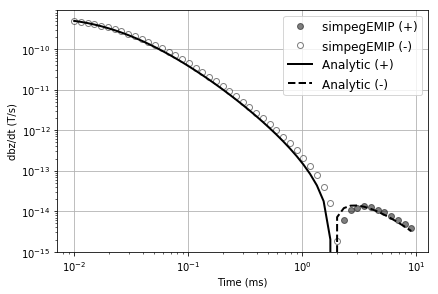

In [115]:
ms = 1e3
scale = 1.
plt.loglog(rx.times*ms, data.flatten()*scale, 'ko', alpha = 0.5)
plt.loglog(rx.times*ms, -data.flatten()*scale, 'ko', markerfacecolor="w", alpha = 0.5)
plt.loglog(rx.times*ms, -dhzdt.flatten(), 'k-', lw=2)
plt.loglog(rx.times*ms, dhzdt.flatten(), 'k--', lw=2)
plt.grid(True)
plt.tight_layout()
plt.xlabel("Time (ms)")
plt.ylabel("dbz/dt (T/s)")
plt.legend(("simpegEMIP (+)", "simpegEMIP (-)", "Analytic (+)", "Analytic (-)"), fontsize = 12)